In [15]:
from dotenv import load_dotenv

load_dotenv()



True

In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()



In [ ]:
from langchain.chat_models import init_chat_model
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from langchain_core.tools import tool

# reducer function to add messages to the state
# add_messages is a function that appends messages to the state
llm = init_chat_model("google_genai:gemini-2.0-flash")

class State(TypedDict):
    messages:Annotated[list, add_messages]# use to preserve the order of the messages in human and ai lable format



@tool
def get_stock_price(symbol:str) -> float:
    """
    Get the stock price of given stock symbol
    parameters:
    - symbol: str
    returns:
    - float: stock price of the given symbol
    """

    return {
        "MSFT": 234.56,
        "GOOG": 2824.12,
        "AAPL": 180.77,
        "AMZN": 3384.12,
        "TSLA": 230.12,
        "META": 300.12,
        "NVDA": 230.12,
        "NFLX": 400.12,
    }.get(symbol,0.0)

tools = [get_stock_price] # list of tools to be used in the chatbot


KeyboardInterrupt: 

In [18]:
llm_with_tools= llm.bind_tools(tools)


def chatbot(state: State) -> State:
    state["messages"].append(llm_with_tools .invoke(state["messages"]))
    return state

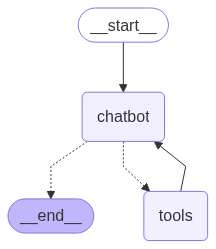

In [19]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition

builder = StateGraph(State)

builder.add_node("chatbot", chatbot)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "chatbot")
builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
builder.add_edge("tools", "chatbot")


graph = builder.compile(checkpointer=memory)


from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
state = None # initial state is none

while True:
    message = input("Enter a message: ")
    if message == "" or message == "quit" or message == "exit":
        break

    if state is None:
        state: State={
            "messages":[{"role" : "user", "content" : message}]
        }
    else:
        state["messages"].append({"role": "user", "content": message})


    
    result = graph.invoke(state)
    print("Bot: ",result["messages"][-1].content)


In [21]:
config = {"configurable": {'thread_id': '1'}}



state =graph.invoke({"messages": [{"role": "user", "content": "what is the stock price of 10 MSFT? add total"}]},config=config)
print(state["messages"][-1].content)


state =graph.invoke({"messages": [{"role": "user", "content": "what is the stock price of GOOG? and add it to previous total"}]},config=config)
print(state["messages"][-1].content)




The stock price of MSFT is 234.56. The total stock price of 10 MSFT is 2345.6.
The stock price of GOOG is 2824.12. Adding it to the previous total 2345.6, the new total is 5169.72.


In [22]:
state =graph.invoke({"messages": [{"role": "user", "content": "what is the stock price of AAPL? and add it to total"}]},config=config)
print(state["messages"][-1].content)

The stock price of AAPL is 180.77. Adding it to the previous total 5169.72, the new total is 5350.49.
